# Clustering

#### Import the libraries

In [403]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go


# Add the root project directory to the Python path
project_root = Path.cwd().parent  # This will get the project root since the notebook is in 'notebooks/'
sys.path.append(str(project_root))
from configs.path_config import CONFIG_DIR, OUTPUT_DIR

#### Load the data

In [404]:
# Load the strain data
df_strain = pd.read_csv(OUTPUT_DIR / 'strain_distributions' / 'N-B_Far_Comp_20091129120000_20210611160000_strain_distribution.csv')
df_strain.isna().sum().sum()
# df_strain = df_strain.iloc[0:4700,:]
df_strain


Timestamp  63.79  63.69  63.589999999999996  \
0      2009-11-29 120000    -21    -24                 -28   
1      2009-11-29 160000    -20    -23                 -24   
2      2009-11-29 200000    -36    -39                 -42   
3      2009-11-30 000000    -32    -34                 -35   
4      2009-11-30 040000    -16    -18                 -20   
...                  ...    ...    ...                 ...   
24216  2021-06-10 200000   -114   -104                 -96   
24217  2021-06-11 000000    -90    -84                 -79   
24218  2021-06-11 040000    -95    -93                 -89   
24219  2021-06-11 080000   -111   -102                 -93   
24220  2021-06-11 120000    -93    -88                 -83   

       63.489999999999995  63.39  63.28  63.18  63.08  62.98  ...  1.02  0.91  \
0                     -25    -21    -19    -12     -8     -4  ...     7    10   
1                     -27    -28    -28    -25    -23    -22  ...    19    20   
2                     -37    -36    -33    -29    -26    -24  ...     3     3   
3                     -30    -31    -28    -25    -21    -19  ...     5     3   
4                     -15    -13    -10     -8     -5     13  ...    -3    -4   
...                   ...    ...    ...    ...    ...    ...  ...   ...   ...   
24216                -103   -114   -123   -126   -126   -116  ...   -15   -25   
24217                 -90   -107   -123   -136   -147   -141  ...    -9   -20   
24218                 -99   -113   -126   -134   -141   -141  ...   -44   -48   
24219                -106   -124   -139   -146   -151   -145  ...   -11   -19   
24220                 -93   -107   -121   -130   -139   -138  ...   -16   -26   

       0.8099999999999999  0.7100000000000001  0.61  0.5099999999999999  \
0                      14                  15    10                   7   
1                      21                  21    20                  19   
2                       4                   4    -1                  -5   
3                      -1                  -2    -4                  -7   
4                      -5                  -6   -11                 -14   
...                   ...                 ...   ...                 ...   
24216                 -35                 -10    23                  38   
24217                 -30                  -9    20                  32   
24218                 -51                 -27     4                  17   
24219                 -26                  -3    28                  41   
24220                 -35                 -16    12                  22   

       0.41000000000000003  0.29999999999999993  0.20000000000000007  \
0                        8                    8                    8   
1                       19                   18                   17   
2                       -5                   -6                   -6   
3                       -8                  -10                  -12   
4                      -15                  -17                  -18   
...                    ...                  ...                  ...   
24216                   22                    7                    6   
24217                   13                   -4                   -1   
24218                   -3                  -22                  -20   
24219                   24                    8                    7   
24220                    2                  -17                  -11   

       0.09999999999999998  
0                        6  
1                       18  
2                       -7  
3                      -11  
4                      -16  
...                    ...  
24216                    7  
24217                    6  
24218                  -15  
24219                   10  
24220                   -1  

[24221 rows x 631 columns]

#### Outliers

In [405]:
# Find outliers
df_strain_data = df_strain.drop(columns = 'Timestamp')
means = df_strain_data.mean(axis=1)  # Calculate mean for each row

# Calculate the mean and standard deviation of the row means
mean_val = means.mean()
std_val = means.std()

# Define a threshold for outliers (3 standard deviations from the mean)
threshold = 1

# Find outliers: rows where the absolute deviation from the mean is greater than the threshold
outliers = means[np.abs(means - mean_val) > threshold * std_val]
print("Outliers:")
print(outliers)

df_strain = df_strain.drop(outliers.index)
print("Number of outliers removed: ", len(outliers))

Outliers:
4663    -67798.696825
7798     67861.150794
7799     67861.150794
11783    67893.668254
dtype: float64
Number of outliers removed:  4


In [406]:
zeros = df_strain_data[df_strain_data.eq(0).all(axis=1)].index
zeros

Index([], dtype='int64')

#### Perform PCA on the data

In [407]:
# Exclude timestamp in column 0
strain_data = df_strain.iloc[:, 1:]
strain_data

63.79  63.69  63.589999999999996  63.489999999999995  63.39  63.28  \
0        -21    -24                 -28                 -25    -21    -19   
1        -20    -23                 -24                 -27    -28    -28   
2        -36    -39                 -42                 -37    -36    -33   
3        -32    -34                 -35                 -30    -31    -28   
4        -16    -18                 -20                 -15    -13    -10   
...      ...    ...                 ...                 ...    ...    ...   
24216   -114   -104                 -96                -103   -114   -123   
24217    -90    -84                 -79                 -90   -107   -123   
24218    -95    -93                 -89                 -99   -113   -126   
24219   -111   -102                 -93                -106   -124   -139   
24220    -93    -88                 -83                 -93   -107   -121   

       63.18  63.08  62.98  62.879999999999995  ...  1.02  0.91  \
0        -12     -8     -4                   0  ...     7    10   
1        -25    -23    -22                 -15  ...    19    20   
2        -29    -26    -24                 -22  ...     3     3   
3        -25    -21    -19                 -16  ...     5     3   
4         -8     -5     13                  17  ...    -3    -4   
...      ...    ...    ...                 ...  ...   ...   ...   
24216   -126   -126   -116                -105  ...   -15   -25   
24217   -136   -147   -141                -131  ...    -9   -20   
24218   -134   -141   -141                -138  ...   -44   -48   
24219   -146   -151   -145                -137  ...   -11   -19   
24220   -130   -139   -138                -135  ...   -16   -26   

       0.8099999999999999  0.7100000000000001  0.61  0.5099999999999999  \
0                      14                  15    10                   7   
1                      21                  21    20                  19   
2                       4                   4    -1                  -5   
3                      -1                  -2    -4                  -7   
4                      -5                  -6   -11                 -14   
...                   ...                 ...   ...                 ...   
24216                 -35                 -10    23                  38   
24217                 -30                  -9    20                  32   
24218                 -51                 -27     4                  17   
24219                 -26                  -3    28                  41   
24220                 -35                 -16    12                  22   

       0.41000000000000003  0.29999999999999993  0.20000000000000007  \
0                        8                    8                    8   
1                       19                   18                   17   
2                       -5                   -6                   -6   
3                       -8                  -10                  -12   
4                      -15                  -17                  -18   
...                    ...                  ...                  ...   
24216                   22                    7                    6   
24217                   13                   -4                   -1   
24218                   -3                  -22                  -20   
24219                   24                    8                    7   
24220                    2                  -17                  -11   

       0.09999999999999998  
0                        6  
1                       18  
2                       -7  
3                      -11  
4                      -16  
...                    ...  
24216                    7  
24217                    6  
24218                  -15  
24219                   10  
24220                   -1  

[24217 rows x 630 columns]

In [ ]:
# Scale the data
# scaler = StandardScaler()
scaler = MinMaxScaler()

strain_data = scaler.fit_transform(df_strain_data)
strain_data = pd.DataFrame(strain_data, columns=df_strain_data.columns)
strain_data

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

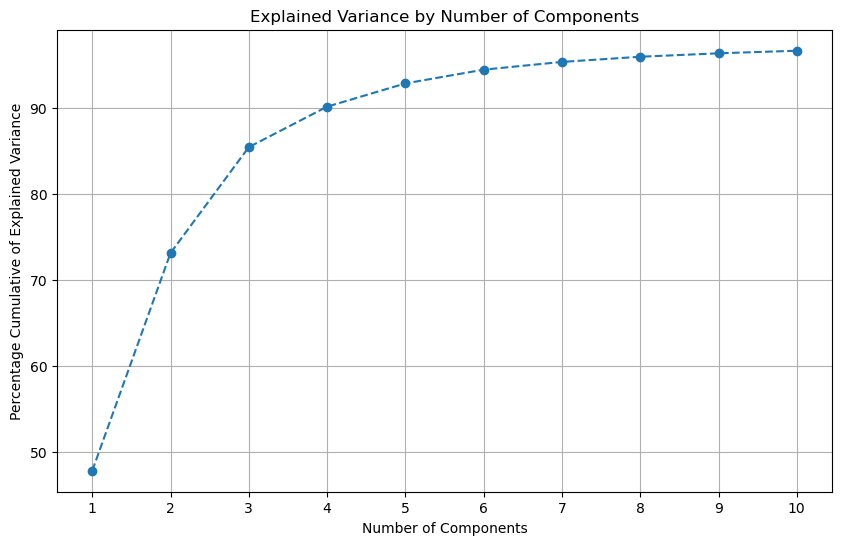

In [ ]:
# Fit PCA on the entire strain data (matrix-wise)
# Set the number of components directly (e.g., 5 components)
pca = PCA(n_components=10)
pca.fit(strain_data)
# 
# Get the explained variance ratio
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(per_var) + 1), per_var.cumsum(), marker="o", linestyle="--")
plt.grid()
plt.ylabel("Percentage Cumulative of Explained Variance")
plt.xlabel("Number of Components")
plt.xticks(range(1, len(per_var) + 1, 1))
plt.title("Explained Variance by Number of Components")
plt.show()

In [ ]:
def do_pca(n_components, strain_data):
    # Perform PCA
    pca = PCA(n_components=n_components)

    # Fit PCA on the entire strain data (matrix-wise)
    pca.fit(strain_data)

    # Apply PCA to the entire strain data (matrix-wise)
    pca_results = pca.transform(strain_data)

    # Normalize the results
    normalized_pca_components = StandardScaler().fit_transform(pca_results)

    # Convert results into a DataFrame
    df_pca = pd.DataFrame(normalized_pca_components, columns=[f'PC{i+1}' for i in range(n_components)])

    # Add timestamps back
    df_pca.insert(0, 'Timestamp', df_strain['Timestamp'].values)

    return normalized_pca_components, df_pca

n_components = 8
normalized_pca_components, df_pca = do_pca(n_components, strain_data)

#### KMeans Clustering

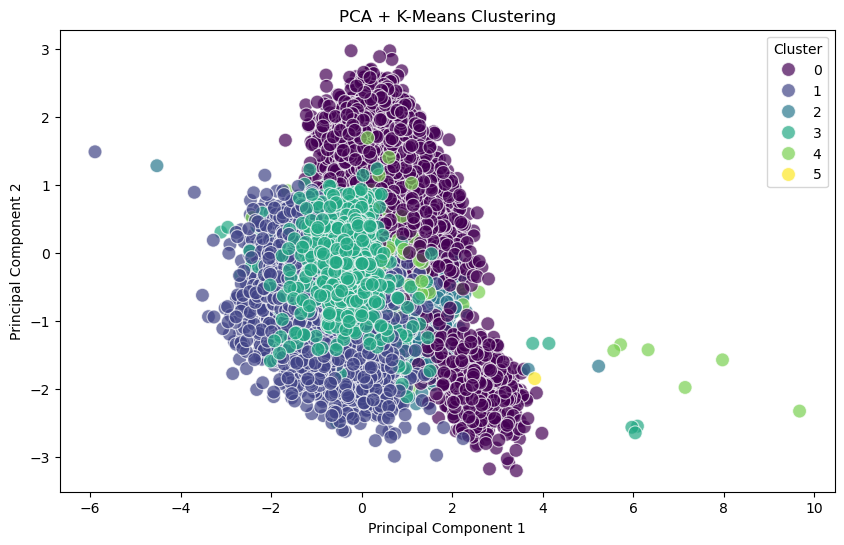

Timestamp  Cluster  63.79  63.69  63.589999999999996  \
0      2009-11-29 120000        4    -21    -24                 -28   
1      2009-11-29 160000        0    -20    -23                 -24   
2      2009-11-29 200000        4    -36    -39                 -42   
3      2009-11-30 000000        0    -32    -34                 -35   
4      2009-11-30 040000        4    -16    -18                 -20   
...                  ...      ...    ...    ...                 ...   
24216  2021-06-10 200000        3   -114   -104                 -96   
24217  2021-06-11 000000        3    -90    -84                 -79   
24218  2021-06-11 040000        3    -95    -93                 -89   
24219  2021-06-11 080000        3   -111   -102                 -93   
24220  2021-06-11 120000        3    -93    -88                 -83   

       63.489999999999995  63.39  63.28  63.18  63.08  ...  1.02  0.91  \
0                     -25    -21    -19    -12     -8  ...     7    10   
1                     -27    -28    -28    -25    -23  ...    19    20   
2                     -37    -36    -33    -29    -26  ...     3     3   
3                     -30    -31    -28    -25    -21  ...     5     3   
4                     -15    -13    -10     -8     -5  ...    -3    -4   
...                   ...    ...    ...    ...    ...  ...   ...   ...   
24216                -103   -114   -123   -126   -126  ...   -15   -25   
24217                 -90   -107   -123   -136   -147  ...    -9   -20   
24218                 -99   -113   -126   -134   -141  ...   -44   -48   
24219                -106   -124   -139   -146   -151  ...   -11   -19   
24220                 -93   -107   -121   -130   -139  ...   -16   -26   

       0.8099999999999999  0.7100000000000001  0.61  0.5099999999999999  \
0                      14                  15    10                   7   
1                      21                  21    20                  19   
2                       4                   4    -1                  -5   
3                      -1                  -2    -4                  -7   
4                      -5                  -6   -11                 -14   
...                   ...                 ...   ...                 ...   
24216                 -35                 -10    23                  38   
24217                 -30                  -9    20                  32   
24218                 -51                 -27     4                  17   
24219                 -26                  -3    28                  41   
24220                 -35                 -16    12                  22   

       0.41000000000000003  0.29999999999999993  0.20000000000000007  \
0                        8                    8                    8   
1                       19                   18                   17   
2                       -5                   -6                   -6   
3                       -8                  -10                  -12   
4                      -15                  -17                  -18   
...                    ...                  ...                  ...   
24216                   22                    7                    6   
24217                   13                   -4                   -1   
24218                   -3                  -22                  -20   
24219                   24                    8                    7   
24220                    2                  -17                  -11   

       0.09999999999999998  
0                        6  
1                       18  
2                       -7  
3                      -11  
4                      -16  
...                    ...  
24216                    7  
24217                    6  
24218                  -15  
24219                   10  
24220                   -1  

[24217 rows x 632 columns]

In [ ]:
def kmeans_clustering(data, n_clusters):
   
    kmeans = KMeans(n_clusters, random_state=42)
    clusters = kmeans.fit_predict(normalized_pca_components)

    plt.figure(figsize=(10, 6))

    # Scatter plot with the clusters
    sns.scatterplot(x=normalized_pca_components[:, 0], y=normalized_pca_components[:, 1], hue=clusters, palette="viridis", s=100, alpha=0.7)

    # Label the axes
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA + K-Means Clustering")

    # Show the plot
    plt.legend(title='Cluster')
    plt.show()

    # Add cluster labels to your original data (without overwriting)
    data_with_KMeans = df_strain.copy()  # Make a copy to preserve the original DataFrame

    # Insert the clusters as the second column (at index 1)
    data_with_KMeans.insert(1, 'Cluster', clusters)

    # Show the updated DataFrame with the Cluster column as the second column
    return data_with_KMeans

n_components = 8
normalized_pca_components, df_pca = do_pca(n_components, strain_data)

n_clusters = 6
data_with_KMeans = kmeans_clustering(normalized_pca_components, n_clusters)
data_with_KMeans

#### Plot the cluster assignment over time

In [ ]:
# Assuming 'Timestamp' is a column with string dates, we convert it to datetime format.
data_with_KMeans['Timestamp'] = pd.to_datetime(data_with_KMeans['Timestamp'])

# Create the Plotly figure
fig = go.Figure()

# Add a scatter plot (you can choose 'line' or 'scatter' depending on the style you want)
fig.add_trace(go.Scatter(x=data_with_KMeans['Timestamp'], 
                         y=data_with_KMeans['Cluster'], 
                         mode='markers+lines',  # markers and lines
                         marker=dict(size=8, 
                                     color=data_with_KMeans['Cluster'],  # Color by cluster value
                                     colorscale='Viridis',  # You can change the colorscale here
                                     colorbar=dict(title='Cluster')),  # Add a color bar to show the scale
                         line=dict(width=1, color='grey')))  # Customizing line color and width

# Update layout with title and labels
fig.update_layout(
    title='Assignment to Clusters Over Time with KMeans Clustering',
    xaxis_title='Time',
    yaxis_title='Cluster',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    yaxis=dict(tickmode='linear', tick0=0, dtick=1)  # Set y-tick step size to 1
)

# Show the figure
fig.show()

#### Plot the mean distribution for each cluster and the standard deviation

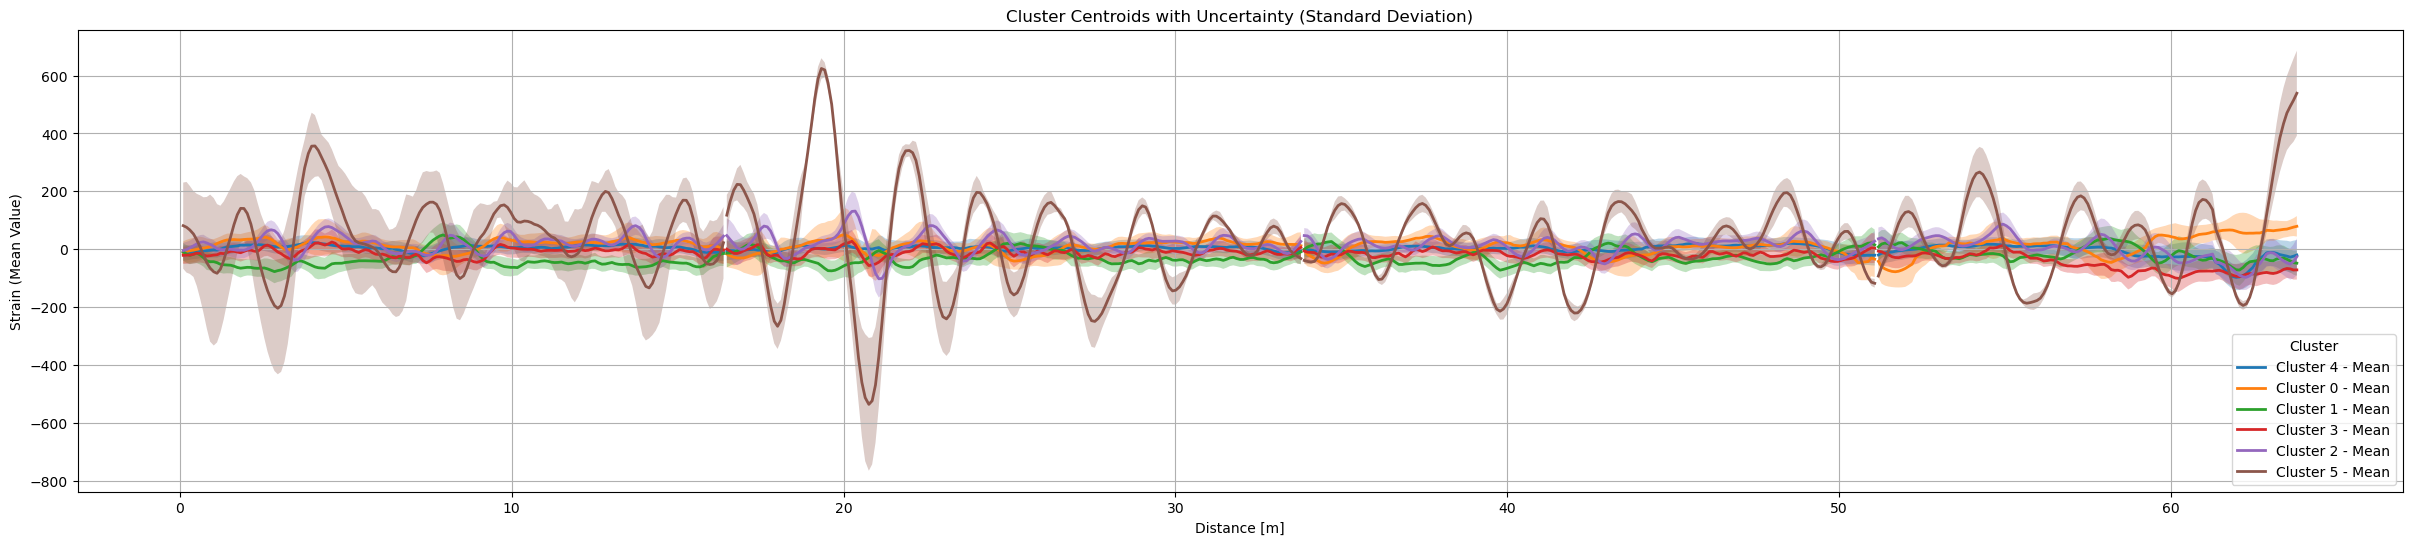

In [ ]:
def plot_cluster_mean_and_std(df, clusters_to_keep):
    # Check if the user wants to keep all clusters
    if clusters_to_keep == ['all']:
        clusters_to_keep = df['Cluster'].unique()  # Use the correct attribute to get unique cluster indices

    # Group the data by Cluster and compute the mean strain values for each cluster
    df_cluster_mean = df.drop(columns='Timestamp').groupby('Cluster').mean()

    # Convert column names (assumed to be distances along the beam) to numeric values
    x_values = pd.to_numeric(df_cluster_mean.columns, errors='coerce')  # Convert column names to numeric

    # Filter the DataFrame to keep only the selected rows
    df_cluster = df_cluster_mean.loc[clusters_to_keep]  # Use .loc for row selection

    # Step 1: Calculate the standard deviation of strain values for each cluster
    df_cluster_std = df.drop(columns='Timestamp').groupby('Cluster').std()

    # Step 2: Plot the cluster centroids with uncertainty (shaded region)
    plt.figure(figsize=(30, 6))

    # Loop over clusters and plot their mean strain and uncertainty (standard deviation)
    for cluster in df_cluster.index:
        # Plot the mean strain distribution for the current cluster
        plt.plot(x_values, df_cluster.loc[cluster], label=f'Cluster {cluster} - Mean', linewidth=2)
        
        # Plot the uncertainty region (standard deviation) around the mean
        plt.fill_between(x_values, 
                         df_cluster.loc[cluster] - df_cluster_std.loc[cluster], 
                         df_cluster.loc[cluster] + df_cluster_std.loc[cluster], 
                         alpha=0.3)  # Shaded region for uncertainty

    # Customizing the plot
    plt.xlabel('Distance [m]')
    plt.ylabel('Strain (Mean Value)')
    plt.title('Cluster Centroids with Uncertainty (Standard Deviation)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

# Example usage
clusters_to_keep = ['all'] # 'all' or a list of cluster indices
plot_cluster_mean_and_std(data_with_KMeans, clusters_to_keep)

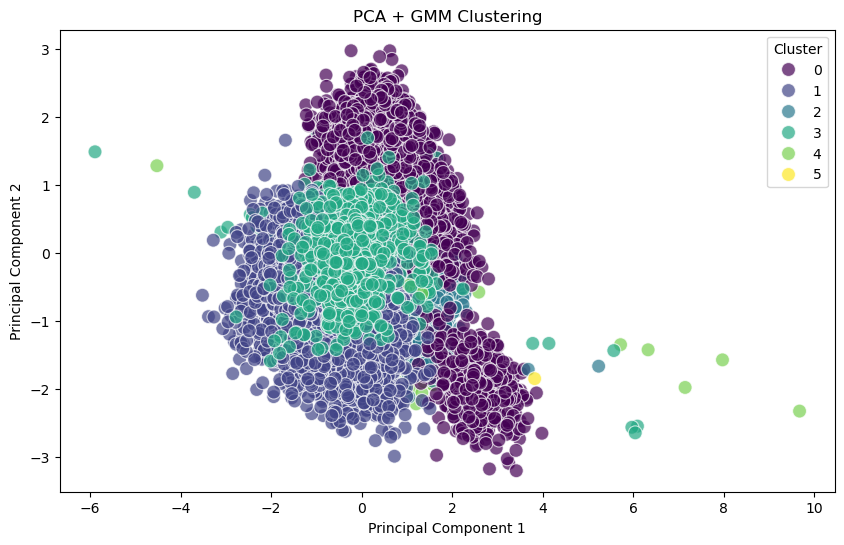

In [ ]:
def gmm_clustering(data, n_clusters):
   
    # Fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clusters = gmm.fit_predict(normalized_pca_components)

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=normalized_pca_components[:, 0], y=normalized_pca_components[:, 1], hue=clusters, palette="viridis", s=100, alpha=0.7)

    # Label the axes
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA + GMM Clustering")

    # Show the plot
    plt.legend(title='Cluster')
    plt.show()

    # Add the GMM cluster labels to the original data (without overwriting)
    data_with_GMM = df_strain.copy()  # Make a copy to preserve the original DataFrame
    data_with_GMM.insert(1, 'Cluster', clusters)  # Insert GMM clusters as the second column

    # Show the updated DataFrame with the Cluster column as the second column
    return data_with_GMM

n_components = 8
normalized_pca_components, df_pca = do_pca(n_components, strain_data)

n_clusters = 6
data_with_GMM = gmm_clustering(normalized_pca_components, n_clusters)

In [ ]:
# Assuming 'Timestamp' is a column with string dates, we convert it to datetime format.
data_with_GMM['Timestamp'] = pd.to_datetime(data_with_GMM['Timestamp'])

# Create the Plotly figure
fig = go.Figure()

# Add a scatter plot (you can choose 'line' or 'scatter' depending on the style you want)
fig.add_trace(go.Scatter(x=data_with_GMM['Timestamp'], 
                         y=data_with_GMM['Cluster'], 
                         mode='markers+lines',  # markers and lines
                         marker=dict(size=8, 
                                     color=data_with_GMM['Cluster'],  # Color by cluster value
                                     colorscale='Viridis',  # You can change the colorscale here
                                     colorbar=dict(title='Cluster')),  # Add a color bar to show the scale
                         line=dict(width=1, color='grey')))  # Customizing line color and width

# Update layout with title and labels
fig.update_layout(
    title='Assignment to Clusters Over Time with Gaussian Mixture Model (GMM) Clustering',
    xaxis_title='Time',
    yaxis_title='Cluster',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    yaxis=dict(tickmode='linear', tick0=0, dtick=1)  # Set y-tick step size to 1
)

# Show the figure
fig.show()

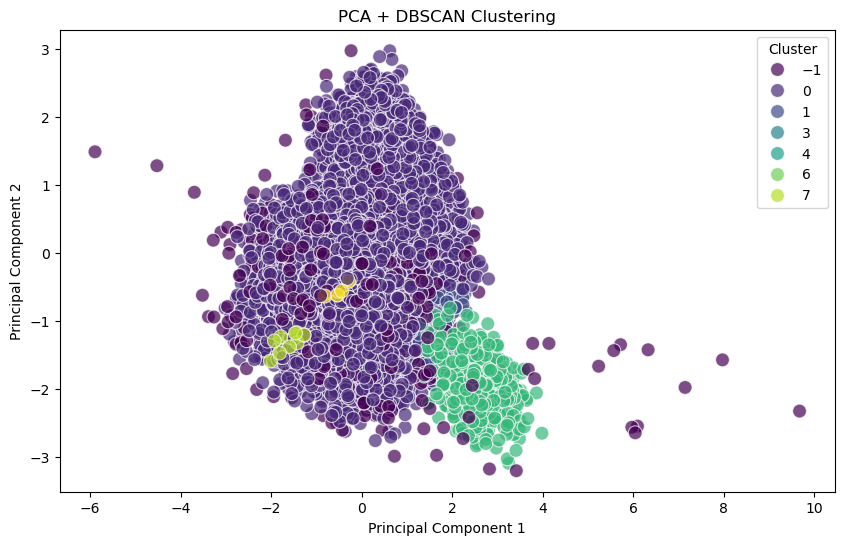

In [ ]:
def dbscan_clustering(data, eps=0.5, min_samples=5):
    """
    Perform DBSCAN clustering on the provided data and visualize the results.

    Parameters:
    - data: The dataset to cluster.
    - eps: The maximum distance between two samples for them to be considered as in the same neighborhood.
    - min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
    """
    # Fit the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=clusters, palette="viridis", s=100, alpha=0.7)

    # Label the axes
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA + DBSCAN Clustering")

    # Show the plot
    plt.legend(title='Cluster')
    plt.show()

    # Add the DBSCAN cluster labels to the original data (without overwriting)
    data_with_dbscan = df_strain.copy()  # Make a copy to preserve the original DataFrame
    data_with_dbscan.insert(1, 'Cluster', clusters)  # Insert DBSCAN clusters as the second column

    # Show the updated DataFrame with the Cluster column as the second column
    return data_with_dbscan

n_components = 5
normalized_pca_components, df_pca = do_pca(n_components, strain_data)

# Call the function with the normalized PCA components
data_with_dbscan = dbscan_clustering(normalized_pca_components, eps=0.5, min_samples=5)

#### Number of clusters

In [ ]:
def evaluate_clusters(data, n_clusters) -> None:

    # Initialize lists to store inertia and Davies-Bouldin index for KMeans
    silhouette_kmeans = []  # Sum of squared distances of samples to their closest cluster center
    db_index_kmeans = []  # Davies-Bouldin Index

    # Initialize lists to store inertia and Davies-Bouldin index for GMM
    silhouette_gmm = []  
    db_index_gmm = []  

    # Initialize lists to store inertia and Davies-Bouldin index for DBSCAN
    silhouette_dbscan = []  
    db_index_dbscan = []  
 

    # Loop over different number of clusters
    for n in range(2, n_clusters + 1):

        # KMeans Clustering
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans_labels = kmeans.fit_predict(data)

        # Davies-Bouldin Index for KMeans
        db_score_kmeans = davies_bouldin_score(data, kmeans_labels)
        db_index_kmeans.append(db_score_kmeans)
        # Silhouette Score for KMeans
        silhouette_kmeans.append(silhouette_score(data, kmeans_labels))
        
        print(f"K-Means - Number of clusters: {n}, Davies-Bouldin Index: {db_score_kmeans}, Silhouette Score: {silhouette_score(data, kmeans_labels)}")

        # GMM Clustering
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm_labels = gmm.fit_predict(data)

        # Davies-Bouldin Index for GMM
        db_score_gmm = davies_bouldin_score(data, gmm_labels)
        db_index_gmm.append(db_score_gmm)
        # Silhouette Score for GMM
        silhouette_gmm.append(silhouette_score(data, gmm_labels))
        
        print(f"GMM - Number of components: {n}, Davies-Bouldin Index: {db_score_gmm}, Silhouette Score: {silhouette_score(data, gmm_labels)}")

        # DBSCAN Clustering (DBSCAN does not require number of clusters, so we use eps and min_samples)
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        dbscan_labels = dbscan.fit_predict(data)

        # Davies-Bouldin Index for DBSCAN (ignoring -1 labels as noise points)
        db_score_dbscan = davies_bouldin_score(data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
        db_index_dbscan.append(db_score_dbscan)
        
        # Silhouette Score for DBSCAN (ignoring -1 labels as noise points)
        silhouette_dbscan.append(silhouette_score(data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]))
        
        print(f"DBSCAN - Davies-Bouldin Index: {db_score_dbscan}, Silhouette Score: {silhouette_score(data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])}")

    # Plot the Elbow graph and Davies-Bouldin Index in subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Elbow Method Plot (Inertia)
    axes[0].plot(range(2, n_clusters+1), silhouette_kmeans, marker='o')
    axes[0].plot(range(2, n_clusters+1), silhouette_gmm, marker='o')
    axes[0].plot(range(2, n_clusters+1), silhouette_dbscan, marker='o')
    axes[0].set_title("Silhouette Score for Different Number of Clusters")
    axes[0].set_xlabel("Number of Clusters")
    axes[0].set_ylabel("Silhouette Score")
    axes[0].legend(['KMeans', 'GMM', 'DBSCAN'])

    # Davies-Bouldin Index Plot
    axes[1].plot(range(2, n_clusters+1), db_index_kmeans, marker='o')
    axes[1].plot(range(2, n_clusters+1), db_index_gmm, marker='o')
    axes[1].plot(range(2, n_clusters+1), db_index_dbscan, marker='o')
    axes[1].set_title("Davies-Bouldin Index for Different Number of Clusters")
    axes[1].set_xlabel("Number of Clusters")
    axes[1].set_ylabel("Davies-Bouldin Index")
    axes[1].legend(['KMeans', 'GMM','DBSCAN'])

    plt.tight_layout()

    plt.show()

# Call the function with the normalized PCA components
n_components = 5
normalized_pca_components, df_pca = do_pca(n_components, strain_data)

n_clusters = 10
data = normalized_pca_components
# evaluate_clusters(data, n_clusters)